In [2]:
"""
PyCaret Experiments Serrano/AUDSOME Phase 1
Gabriel Iuhasz
Anomaly Only

Use pycaret special env:
 conda activate /Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4

Reason: Pycaret not supporting newer version of scikit learn, 0.23.4 latest
"""
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import xgboost as xgb
# from sklearn.externals import joblib
from joblib import dump, load
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
%matplotlib inline

In [3]:
def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, target_names=definitions))
    report = classification_report(y, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)



Common preprocessing for all experiments

In [4]:
print("Checking files in data location ...")
train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
# train_dir = '/home/gabriel/research/dipet/serrano/data'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models
processed



In [5]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

# data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
# processed_dir = os.path.join(train_dir,'processed')
# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# if not os.path.exists(processed_dir):
#     os.makedirs(processed_dir)

Setting paths and datasets


In [6]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

In [7]:
print("Dataset chosen ...")
data = df_anomaly

# Nice print
nice_y = data['target']
data.shape

Dataset chosen ...


(5400, 90)

In [8]:
# Uncomment for removing dummy TODO CHECK if adding back dummy
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

In [9]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']



Splitting dataset into training and ground truth ...


Ploting class distribution ..


/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


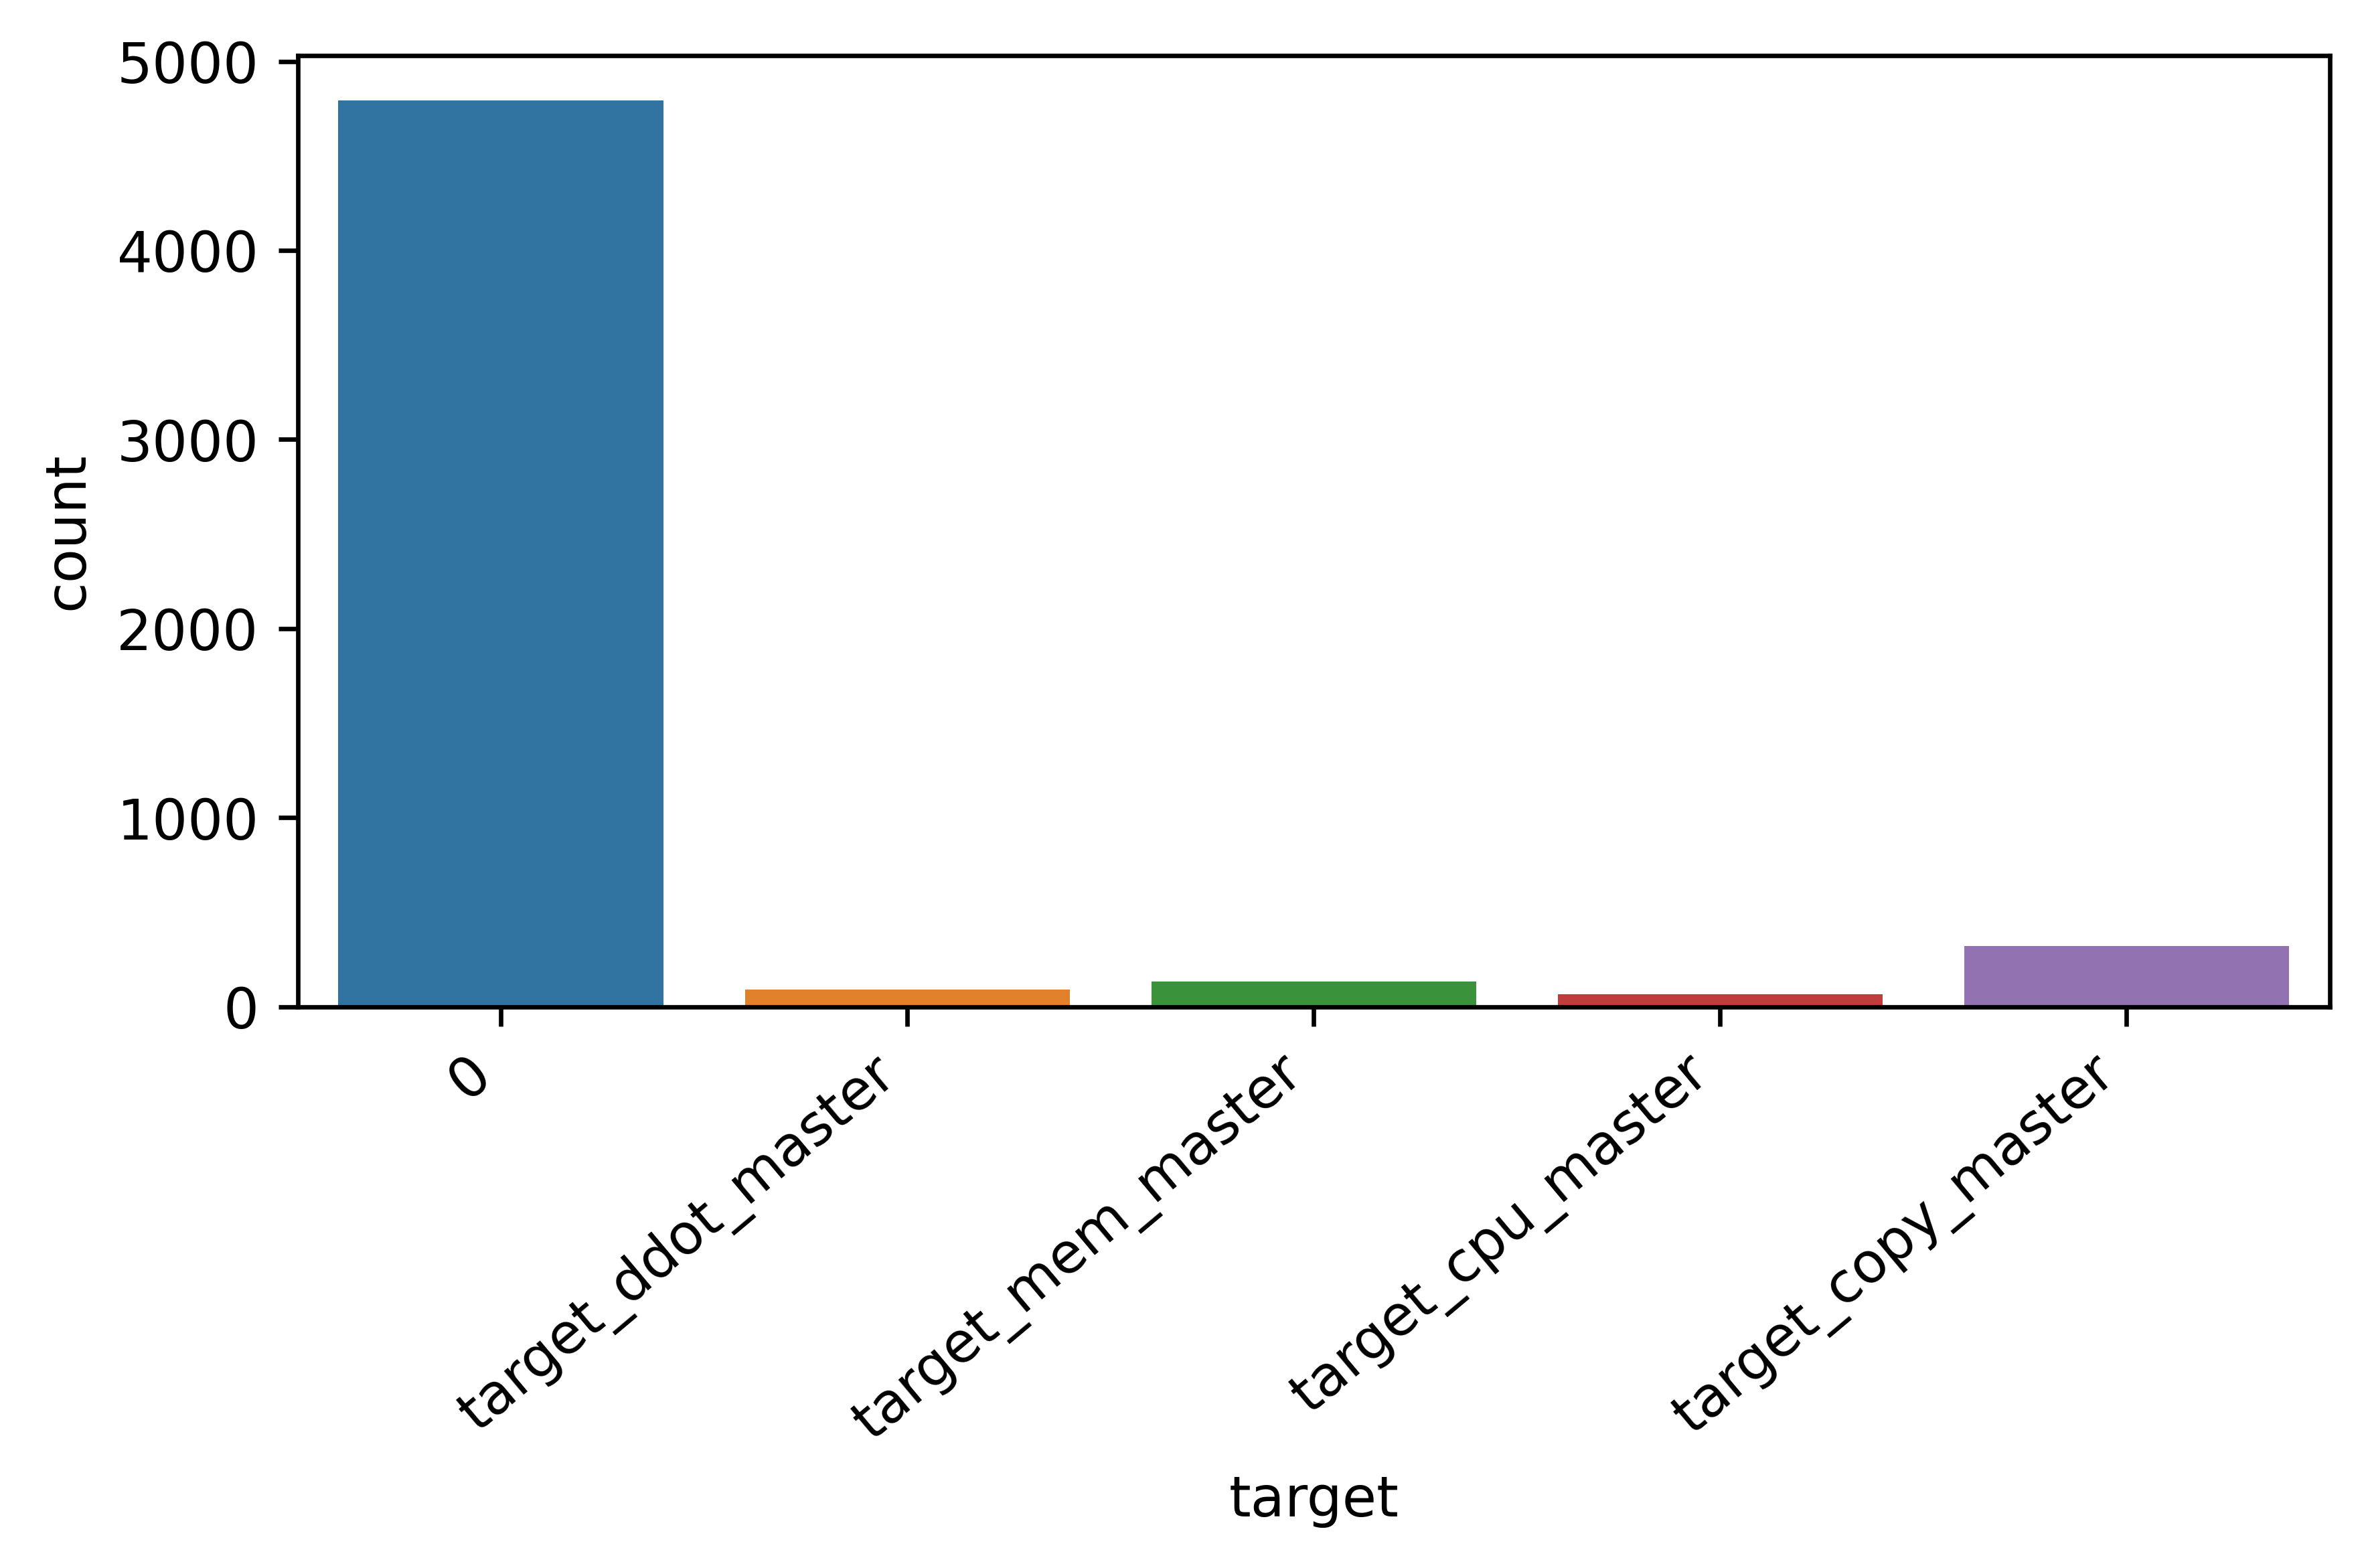

In [10]:
# Plot class distribution
print("Ploting class distribution ..")
plt.figure(dpi=600) #For publication only
pltdist= sns.countplot(nice_y)
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [11]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # transform back to df

Scaling dataset


In [12]:
X['target'] = y
list_columns = list(X.columns.values)
list_columns.pop(-1)

'target'

PyCarret Experiments

In [13]:
# categorical features are detected by mistake, most likely because of low variance features
from pycaret.classification import *
# add target column to scaled dataset
exp_mclf101 = setup(data = X , target = 'target', session_id=1, numeric_features = list_columns, fold_shuffle=True, log_experiment = True, experiment_name = 'pycaret_exp_v1')

,Description,Value
0,session_id,1
1,Target,target
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(5400, 90)"
5,Missing Values,False
6,Numeric Features,89
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9963,0.9977,0.9629,0.9966,0.9963,0.9823,0.9824,0.0310
rf,Random Forest Classifier,0.9952,0.9999,0.9559,0.9954,0.9951,0.9770,0.9772,0.1160
et,Extra Trees Classifier,0.9952,0.9984,0.9596,0.9955,0.9952,0.9773,0.9774,0.0930
lightgbm,Light Gradient Boosting Machine,0.9952,0.9995,0.9600,0.9954,0.9952,0.9771,0.9772,8.8790
catboost,CatBoost Classifier,0.9947,0.9994,0.9561,0.9950,0.9946,0.9745,0.9747,2.1870
xgboost,Extreme Gradient Boosting,0.9944,0.9994,0.9513,0.9946,0.9944,0.9732,0.9734,2.2030
gbc,Gradient Boosting Classifier,0.9939,0.9989,0.9493,0.9944,0.9938,0.9708,0.9709,0.6960
lr,Logistic Regression,0.9934,0.9995,0.9506,0.9935,0.9933,0.9683,0.9684,0.3190
dt,Decision Tree Classifier,0.9931,0.9873,0.9452,0.9936,0.9931,0.9670,0.9672,0.0090
svm,SVM - Linear Kernel,0.9929,0.0000,0.9480,0.9933,0.9928,0.9659,0.9661,0.0180


In [15]:
best

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [17]:
ct = create_model('catboost')

In [18]:
et = create_model('et')

In [19]:
p_et = predict_model(et)
# y_pred = et.predict(X)

custom_scoring_reporting(y_pred=p_et['Label'], y=p_et['target'], definitions=definitions, prefix='et_anomaly')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9969,0.9994,0.9720,0.9971,0.9969,0.9848,0.9848


Accuracy score is: 0.9969154842689698
Ballanced accuracy score is: 0.97197688046026
Jaccard score (micro): 0.993849938499385
Jaccard score (macro): 0.9380288840122635
Jaccard score (weighted): 0.9941538857331578
Full classification report
                    precision    recall  f1-score   support

                 0       1.00      1.00      1.00      1444
target_ddot_master       0.89      1.00      0.94        25
 target_mem_master       0.97      0.94      0.95        32
 target_cpu_master       0.96      0.92      0.94        26
target_copy_master       1.00      1.00      1.00        94

          accuracy                           1.00      1621
         macro avg       0.96      0.97      0.97      1621
      weighted avg       1.00      1.00      1.00      1621

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0       1.00      1.00      1.00      1.00      1.00      1.00      1444
targ

TypeError: classification_report_imbalanced() got an unexpected keyword argument 'output_dict'

In [ ]:
interpret_model(best)

In [14]:
# finalize the model
final_best = finalize_model(best)


In [15]:
# save model to disk
save_model(final_best, 'anomaly_only')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['node_context_switches_total_10.251.0.114:9100',
                                                           'node_cpu_seconds_total_10.251.0.114:9100',
                                                           'node_disk_io_time_seconds_total_10.251.0.114:9100',
                                                           'node_disk_io_time_weigh...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nod

In [ ]:
!mlflow ui

[2022-03-22 16:10:28 +0200] [6397] [INFO] Starting gunicorn 20.1.0
[2022-03-22 16:10:28 +0200] [6397] [INFO] Listening at: http://127.0.0.1:5000 (6397)
[2022-03-22 16:10:28 +0200] [6397] [INFO] Using worker: sync
[2022-03-22 16:10:28 +0200] [6400] [INFO] Booting worker with pid: 6400


/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecate

/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecate

/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecate

/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/Gabriel/anaconda3/envs/Event-Detection-Engine/pycaret_v4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecate